In [6]:
import sys
sys.path.append('/home/axf295/2019/code/spt3g_software/build/')
from spt3g import core, std_processing
from matplotlib import pylab as pl
import numpy as np
import glob

bandcolors = {}
bandcolors['90']  = 'b'
bandcolors['150'] = 'g'
bandcolors['220'] = 'r'

save_dir = '/big_scratch/axf295/2019/CenA/Analyzed_Data/'
rcwsave_dir = '/big_scratch/axf295/2019/RCW38/Analyzed_Data/'

data_loc = '/spt/user/production/calibration/CenA-pixelraster/coaddmaps/'
data_files = glob.glob(data_loc+'6*')+glob.glob(data_loc+'7*')

obsIDs = []#[ '65344256', '52791291','64610968']

for file in data_files:
    obs = file.split('/')[-1].split('.')[0]
    if True:#obs in obsIDs:
        obsIDs.append(obs)
        print(obs)
        
rcwdata_loc = '/spt/user/production/calibration/RCW38-pixelraster/maps/'
rcwdata_files = glob.glob(rcwdata_loc+'6*')+glob.glob(rcwdata_loc+'7*')
rcwobsIDs = []#'64599638']

for file in rcwdata_files:
    rcwobs = file.split('/')[-1].split('.')[0]
    if True:#obs in obsIDs:
        rcwobsIDs.append(rcwobs)
print(rcwobsIDs)        

64380710
65182068
65304794
66545180
65344256
64153936
65758434
64610968
64001331
66750943
68238335
69045478
76069964
72096094
73240056
74915420
70271423
73773950
75495737
70834548
71429632
74346161
72666212
['66451604', '64530457', '63180236', '68994321', '63653698', '65884978', '64569859', '63761957', '63990582', '62721016', '62437886', '64146996', '64371421', '66240875', '64744703', '62462910', '65752840', '63632925', '64599638', '63380372', '64927739', '66071855', '65632251', '65175128', '68187179', '64584651', '63299089', '68940727', '65256447', '66539587', '63398418', '65337318', '66700162', '66450627', '63643116', '62245913', '62303424', '75452436', '72053645', '74872069', '71387365', '70228757', '73196729', '76026696', '70792281', '74302874', '76595619', '73730640', '72623667']


/cvmfs/spt.opensciencegrid.org/py3-v2/RHEL_7_x86_64/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


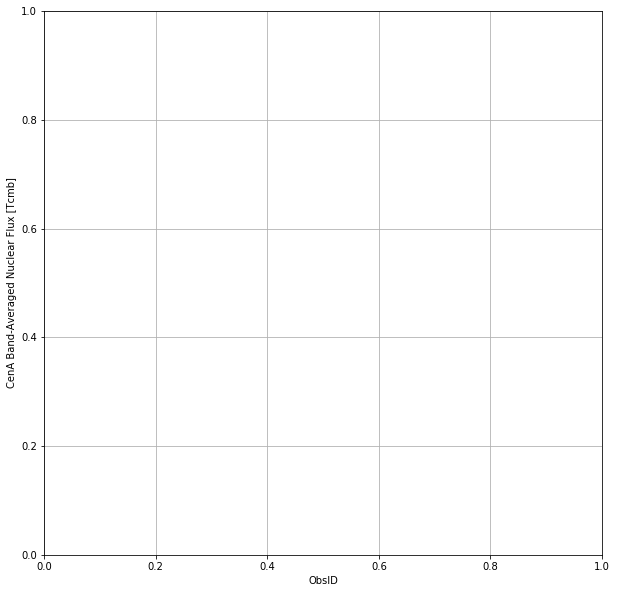

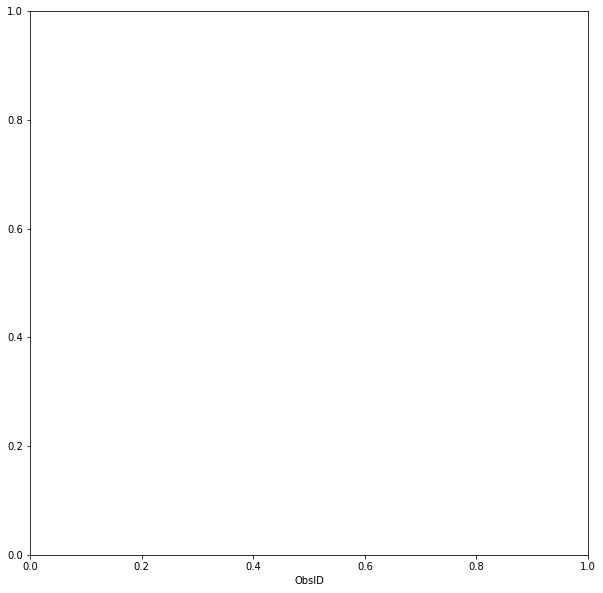

In [8]:
## Plot the Nuclear Flux for each observation.
sys.path.append('/home/axf295/2019/code/spt3g_software/polcal/python/')
import CenA_Map_Utils as CMU
from General_Utils import remove_outliers 

import os
import pickle as pk

bandfig = {'90':1,'150':2,'220':3}
pl.figure(figsize=(10,10))
observations       = []
observationmedians = {}
observationstds    = {}
for obs in obsIDs:
    save_loc = save_dir + '%s/'%obs
    if os.path.exists(save_loc+'CenA_PerBand_Nuclear_Flux.pkl'):
        data = pk.load(open(save_loc+'CenA_PerBand_Nuclear_Flux.pkl','rb'))
        observations.append(obs)
        for band in data:
            if band not in observationmedians:
                observationmedians[band] = []
                observationstds[band]    = []
            cleaneddata = remove_outliers(data[band],m=3)
            m = np.nanmedian(cleaneddata)
            s = np.nanstd(cleaneddata)
            
            observationmedians[band].append(m)
            observationstds[band].append(s)
            pl.errorbar(int(obs),m,yerr=s/np.sqrt(len(cleaneddata)),marker='s',alpha=.5,color=bandcolors[band])
pl.xlabel('ObsID')
pl.ylabel('CenA Band-Averaged Nuclear Flux [Tcmb]')
pl.grid()

pl.show()
## Get RCW38 Flux to overplot
rcwobservations       = []
rcwobservationmedians = {}
rcwobservationstds    = {}
for obs in sorted(rcwobsIDs):
    rcwsave_loc = rcwsave_dir + '%s/'%obs
    if os.path.exists(rcwsave_loc+'RCW38_PerBand_Nuclear_Flux.pkl'):
        data = pk.load(open(rcwsave_loc+'RCW38_PerBand_Nuclear_Flux.pkl','rb'))
        rcwobservations.append(obs)
        for band in data:
            if band not in rcwobservationmedians:
                rcwobservationmedians[band] = []
                rcwobservationstds[band]    = []
            cleaneddata = remove_outliers(data[band],m=3)
            m = np.nanmedian(cleaneddata)
            s = np.nanstd(cleaneddata)
            
            rcwobservationmedians[band].append(m)
            rcwobservationstds[band].append(s)


pl.figure(figsize=(10,10))

for band in observationmedians:
    w = 1./np.asarray(observationstds[band])**2
    meanmean  = np.average(observationmedians[band],weights=w)
    residuals = np.asarray(observationmedians[band])-meanmean
    meanstd   = np.std(observationmedians[band])#/np.sqrt(len(observationmedians[band]))
    
    rcww = 1./np.asarray(rcwobservationstds[band])**2
    rcwmeanmean  = np.average(rcwobservationmedians[band],weights=rcww)
    rcwresiduals = np.asarray(rcwobservationmedians[band])-rcwmeanmean
    rcwmax = np.max(abs(rcwresiduals))
    rcwresiduals/= rcwmax
    rcwresiduals*= np.max(abs(residuals))
    rcwmeanstd   = np.std(rcwobservationmedians[band])#/np.sqrt(len(observationmedians[band]))
    
    
    pl.subplot(3,1,bandfig[band])
    pl.plot(rcwobservations,rcwresiduals,color='k',alpha=.5,label='Rel. RCW38 %sGHz Flux'%band)
    pl.scatter(observations,residuals,color=bandcolors[band],label='%s GHz CenA Flux'%band)
    pl.plot(observations,np.zeros(len(observations)),color='k',ls = '--')
    sigma = np.array(meanstd*np.ones(len(observations)))
    #print(np.asarray(sorted(observations),dtype=float))
    pl.fill_between(np.asarray(sorted(observations),dtype=float),sigma,-sigma,color=bandcolors[band],alpha=.25)
    pl.grid()
    pl.legend()
    pl.ylabel('Flux [Tcmb]')
    so = sorted(observations)
    pl.xlim([float(so[0])-100000,float(so[-1])+100000])
pl.xlabel('ObsID')




pl.show()           
        

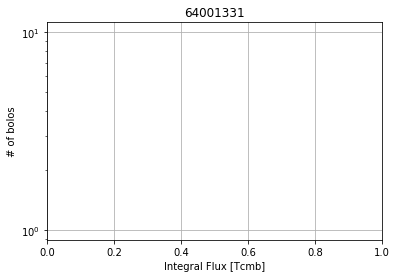

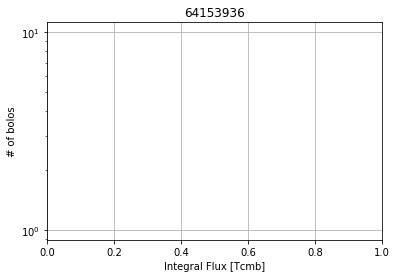

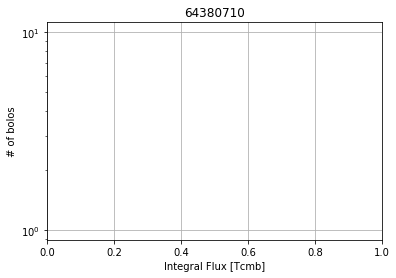

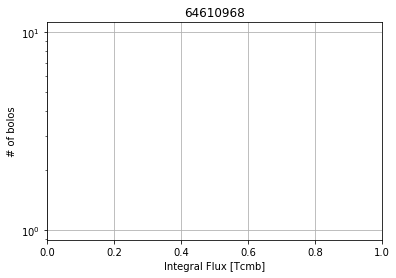

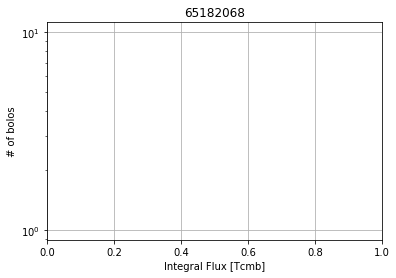

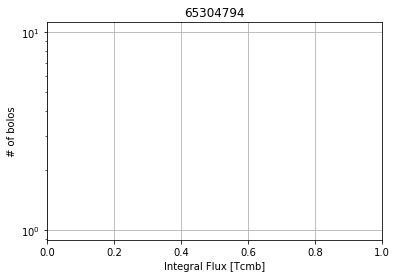

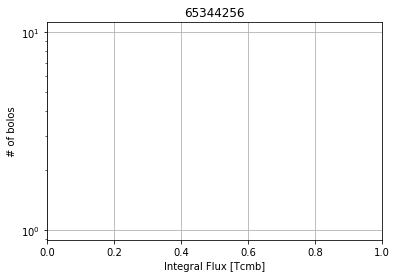

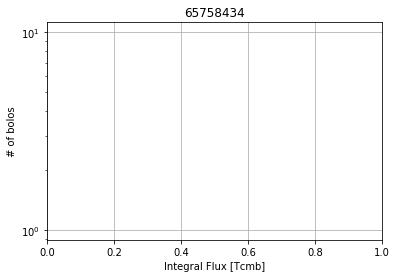

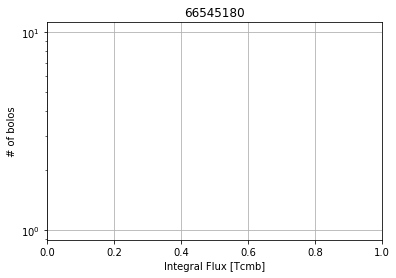

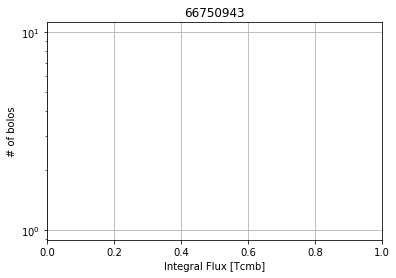

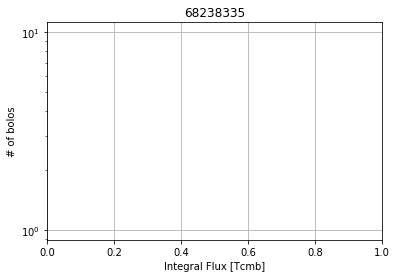

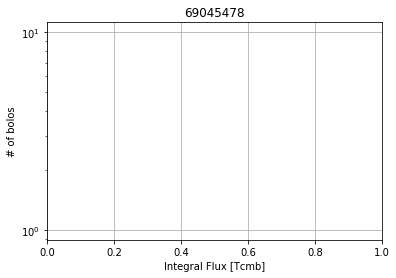

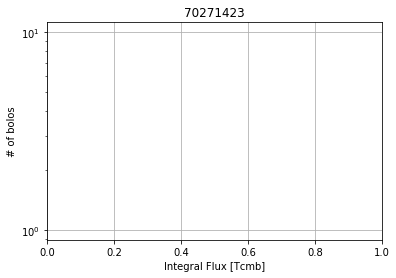

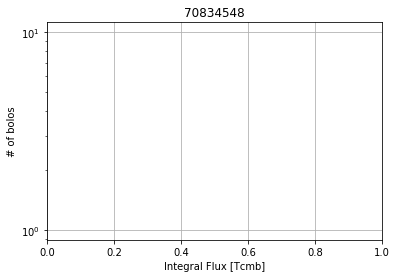

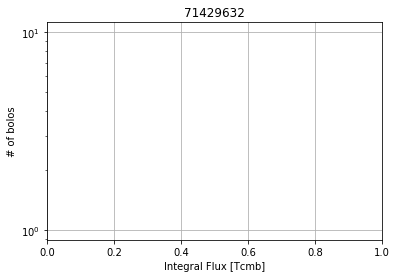

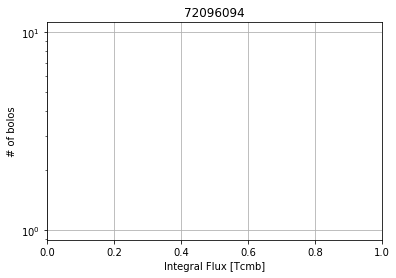

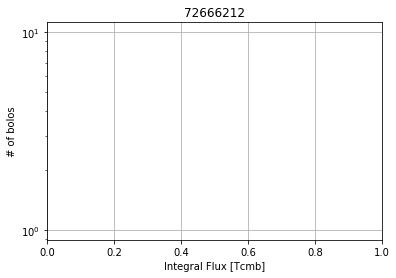

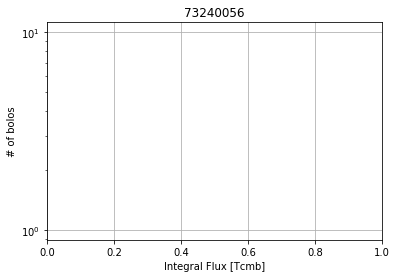

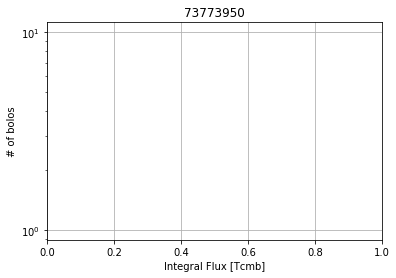

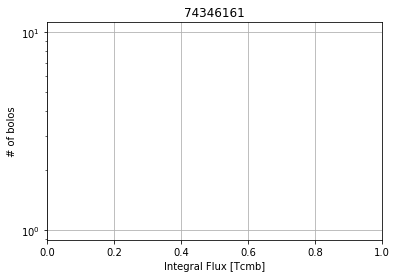

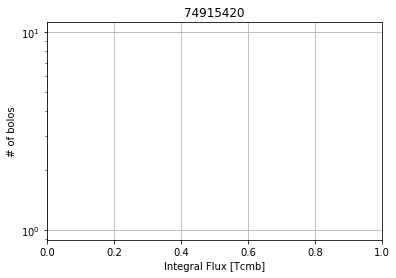

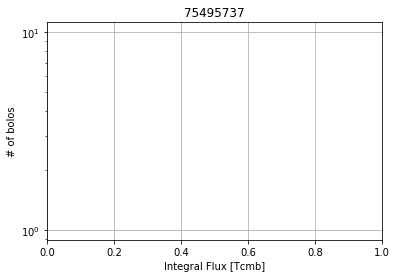

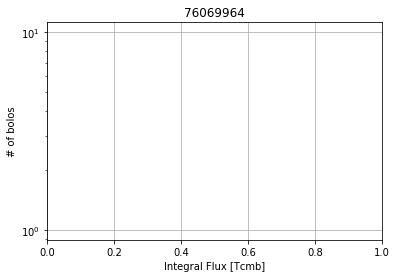

In [9]:
## Plot histograms of the flux from the sn calc function
for obs in sorted(obsIDs):
    pl.figure(obs)
    save_loc = save_dir + '%s/'%obs
    if os.path.exists(save_loc+'CenA_PerBand_Nuclear_Flux.pkl'):
        data = pk.load(open(save_loc+'CenA_PerBand_Nuclear_Flux.pkl','rb'))
        for band in data:
                pl.hist(remove_outliers(data[band]),bins=101,histtype='step',label='%sGHz'%band)
    pl.xlabel('Integral Flux [Tcmb]')
    pl.ylabel('# of bolos')
    pl.yscale('log')
    pl.title(obs)
    pl.grid()

    pl.show()

In [53]:
'''
## Save Fluxes Using the CenA lobe SN calc script
from CenA_Analysis_Functions import Calc_CenA_SN_UsingLobes
for obs in obsIDs:
    pl.figure(obs)
    save_loc = save_dir + '%s/'%obs
    if os.path.exists(save_loc+'CenA_PerBand_Nuclear_Flux.pkl'):
        Calc_CenA_SN_UsingLobes(save_loc,obs,mask_location='/home/axf295/2019/code/CenA/Masks/0p5arcmin/',Output_dir=save_loc,PLOT=0)
'''        

"\n## Save Fluxes Using the CenA lobe SN calc script\nfrom CenA_Analysis_Functions import Calc_CenA_SN_UsingLobes\nfor obs in obsIDs:\n    pl.figure(obs)\n    save_loc = save_dir + '%s/'%obs\n    if os.path.exists(save_loc+'CenA_PerBand_Nuclear_Flux.pkl'):\n        Calc_CenA_SN_UsingLobes(save_loc,obs,mask_location='/home/axf295/2019/code/CenA/Masks/0p5arcmin/',Output_dir=save_loc,PLOT=0)\n"

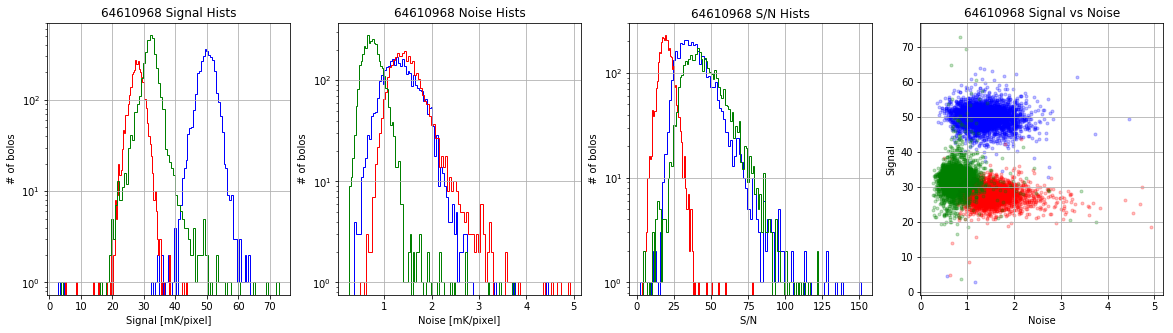

In [4]:
## Plots the Signal and Noise per pixel saved in the previous step
from CenA_Analysis_Functions import Load_Boloprops


perobssignal = {}
perobsnoise  = {}

for obs in obsIDs:
    bp = Load_Boloprops(obs)
    Signal = {}
    Noise  = {}
    Weights= {}
    save_loc = save_dir + '%s/'%obs
    if os.path.exists(save_loc+'Source_Signal_Dictionary.pkl'):
        data = pk.load(open(save_loc+'Source_Signal_Dictionary.pkl','rb'))
        for b in data:
            if np.isfinite(bp[b].band):
                band = str(int(bp[b].band/core.G3Units.GHz))
            else:
                band = '-1'
            if band not in Signal and band != '-1':
                Signal[band] = []
                Noise[band]  = []
                Weights[band]= []
            if band != '-1':
                ## SN > 1, signal not crazy, noise < 5. 
                if data[b][0]/data[b][1] > 1. and data[b][0]<1e6 and data[b][1] <5. :
                    w = 1. #/data[b][1]
                    Signal[band].append(data[b][0]/w - data[b][1])
                    Noise[band].append(data[b][1])
                    Weights[band].append(1/w)
    allthree =0
    for band in Signal:
        ## Gotta have >1000 bolos per band
        if len(Signal[band])>1000:
            allthree+=1
    if allthree == 3:
        perobssignal[obs] = Signal
        perobsnoise[obs]  = Noise
        
        pl.figure(figsize=(20,5))
        pl.subplot(1,4,1)
        for band in Signal:
            pl.hist(Signal[band],bins=101,histtype='step',color=bandcolors[band],label='%sGHz'%band)
        pl.xlabel('Signal [mK/pixel]')
        pl.ylabel('# of bolos')
        pl.yscale('log')
        pl.title('%s Signal Hists'%obs)
        pl.grid()

        pl.subplot(1,4,2)
        for band in Noise:
            pl.hist(Noise[band],bins=101,histtype='step',color=bandcolors[band],label='%sGHz'%band)
        pl.xlabel('Noise [mK/pixel]')
        pl.ylabel('# of bolos')
        pl.yscale('log')
        pl.title('%s Noise Hists'%obs)
        pl.grid()


        pl.subplot(1,4,3)
        for band in Signal:
            pl.hist(np.asarray(Signal[band])/np.asarray(Noise[band]),bins=101,histtype='step',color=bandcolors[band],label='%sGHz'%band)
        pl.xlabel('S/N ')
        pl.ylabel('# of bolos')
        pl.yscale('log')
        pl.title('%s S/N Hists'%obs)
        pl.grid()
        

        pl.subplot(1,4,4)
        for band in Signal:
            pl.scatter(Noise[band],Signal[band],marker = '.',color=bandcolors[band],alpha=.25,label='%sGHz'%band)
        pl.xlabel('Noise')
        pl.ylabel('Signal')
        pl.title('%s Signal vs Noise'%obs)
        pl.grid()
        pl.show()

    

    

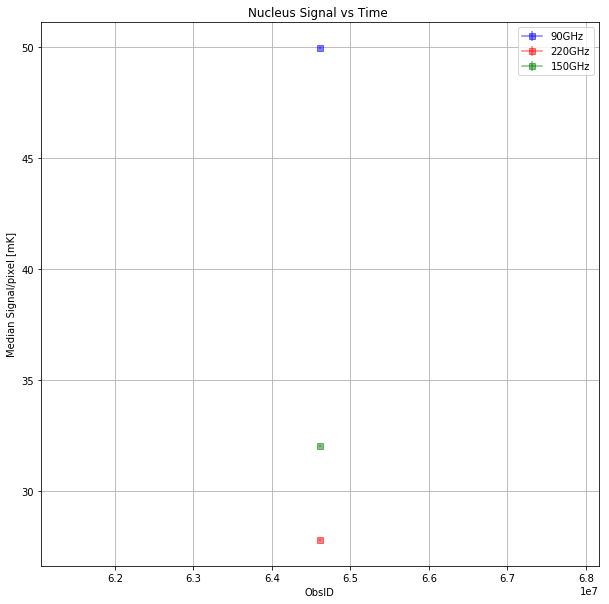

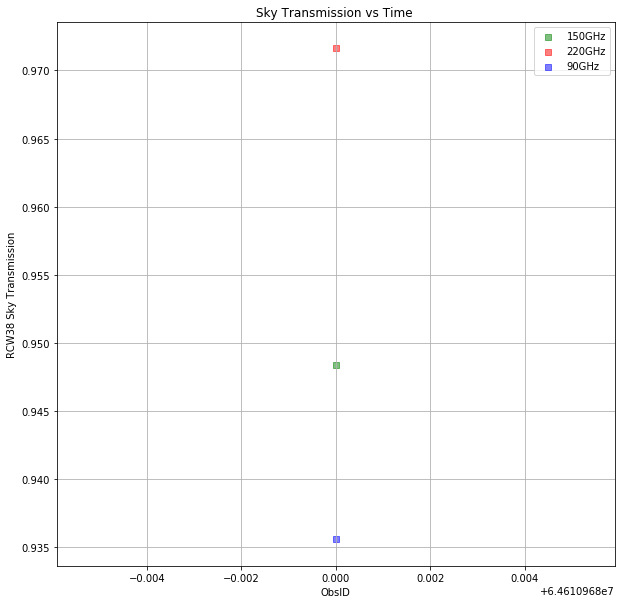

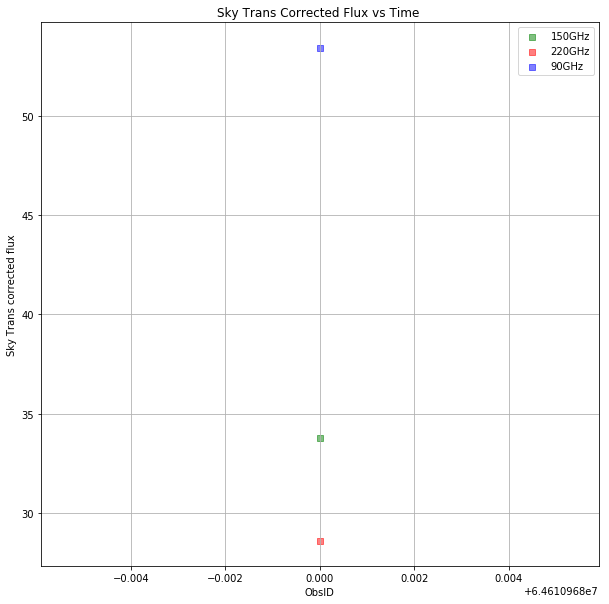

In [5]:
pl.close('all')
pl.figure('SignalvsTime',figsize=(10,10))  
labeled_bands = []
perobsmedians = {}
for obs in perobssignal:
    perobsmedians[obs] = {}
    for band in perobssignal[obs]:
        cleaneddata = remove_outliers(perobssignal[obs][band],m=3)
        if len(cleaneddata)>1000.:
            m = np.nanmedian(cleaneddata)
            perobsmedians[obs][band] = m
            s = np.nanstd(cleaneddata)/np.sqrt(len(cleaneddata))
            if band not in labeled_bands:
                pl.errorbar(int(obs),m,yerr=s,marker='s',color=bandcolors[band],alpha=.5,label='%sGHz'%band)
                labeled_bands.append(band)
            else:
                pl.errorbar(int(obs),m,yerr=s,marker='s',color=bandcolors[band],alpha=.5)
    
pl.grid()
pl.xlabel('ObsID')
pl.ylabel('Median Signal/pixel [mK]')
pl.title('Nucleus Signal vs Time ')
pl.legend()
pl.show()

pl.close('all')
pl.figure('SkyTransvsTime',figsize=(10,10))  
labeled_bands = []
Val2plot = 'RCW38SkyTransmission'
Value = {}
perobs_skytrans = {}
for obs in perobssignal:
    offline_cal = '/spt/data/bolodata/downsampled/CenA-pixelraster/%s/offline_calibration.g3'%obs
    #offline_cal = 'Calframe_replacement.g3'
    for frame in core.G3File(offline_cal):
        #print frame['BolometerProperties'][frame['BolometerProperties'].keys()[0]]
        if Val2plot in frame:
            for band in frame[Val2plot].keys():
                Value[band]= frame[Val2plot][band]
            
        else:
            print(frame)
            print("Pick a value to plot!")
            continue

    perobs_skytrans[obs] = Value
    for band in Value:
        if band not in labeled_bands:
            pl.scatter(int(obs),Value[band],marker='s',color=bandcolors[band],alpha=.5,label='%sGHz'%band)
            labeled_bands.append(band)
        else:
            pl.scatter(int(obs),Value[band],marker='s',color=bandcolors[band],alpha=.5)
    
pl.grid()
pl.xlabel('ObsID')
pl.ylabel('RCW38 Sky Transmission')
pl.title('Sky Transmission vs Time ')
pl.legend()
pl.show()


pl.close('all')
pl.figure('SkyTrans corrected Signal vs Time',figsize=(10,10))  
labeled_bands = []

for obs in perobssignal:
    m = perobsmedians[obs]
    skytrans = perobs_skytrans[obs]
    for band in Value:
        if band not in labeled_bands:
            pl.scatter(int(obs),m[band]/skytrans[band],marker='s',color=bandcolors[band],alpha=.5,label='%sGHz'%band)
            labeled_bands.append(band)
        else:
            pl.scatter(int(obs),m[band]/skytrans[band],marker='s',color=bandcolors[band],alpha=.5)
    
pl.grid()
pl.xlabel('ObsID')
pl.ylabel('Sky Trans corrected flux')
pl.title('Sky Trans Corrected Flux vs Time ')
pl.legend()
pl.show()


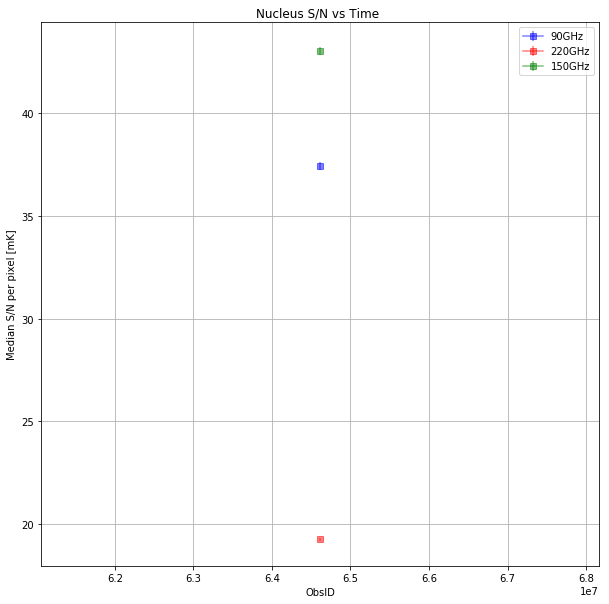

In [6]:
pl.figure('SignalvsTime',figsize=(10,10))  
labeled_bands = []
for obs in perobssignal:
    for band in perobssignal[obs]:
        cleaneddata = remove_outliers(np.asarray(perobssignal[obs][band])/np.asarray(perobsnoise[obs][band]),m=3)
        m = np.nanmedian(cleaneddata)
        s = np.nanstd(cleaneddata)/np.sqrt(len(cleaneddata))
        if band not in labeled_bands:
            pl.errorbar(int(obs),m,yerr=s,marker='s',color=bandcolors[band],alpha=.5,label='%sGHz'%band)
            labeled_bands.append(band)
        else:
            pl.errorbar(int(obs),m,yerr=s,marker='s',color=bandcolors[band],alpha=.5)
    
pl.grid()
pl.xlabel('ObsID')
pl.ylabel('Median S/N per pixel [mK]')
pl.title('Nucleus S/N vs Time ')
pl.legend()
pl.show()

Plotting the Nuclear Flux FP maps
plotting
bolos SN added to dict
51.3560474921 2.05698053005
51.3716821977 1.91017053976
51.3822842757 1.83768927566
32.8253961058 1.93885573425
32.8458570987 1.71151063801
32.8433322312 1.56125334161
29.3085056872 1.80326954543
29.3086039593 1.6669212759
29.3190358648 1.57699905394


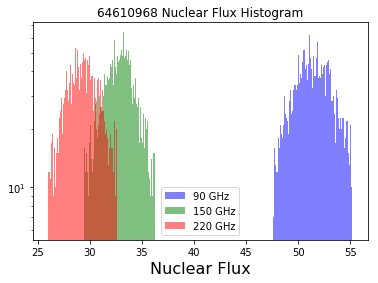

3655 90 GHz bolos plotted


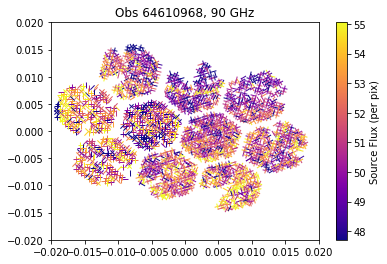

3804 150 GHz bolos plotted


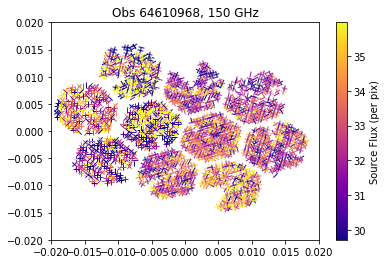

3444 220 GHz bolos plotted


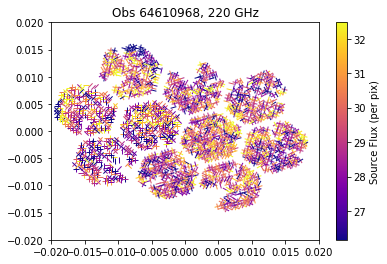

In [7]:
## Plot Focal Plane Maps of Nuclear Flux
PLOT = True
for obsID in obsIDs:
    if PLOT:
        save_loc = save_dir + '%s/'%obsID
        if os.path.exists(save_loc+'Source_Signal_Dictionary.pkl'):
            data = pk.load(open(save_loc+'Source_Signal_Dictionary.pkl','rb'))
        else:
            continue
        

        print('Plotting the Nuclear Flux FP maps')    
        offline_cal = '/spt/data/bolodata/downsampled/CenA-pixelraster/%s/offline_calibration.g3'%obsID
        if not os.path.exists(offline_cal):
            print('Defaulting to latest boloprops file')
            offline_cal = '/spt/user/production/calibration/boloproperties/62679603.g3'
        bolo_band = {}
        for frame in core.G3File(offline_cal):
            for bolo in frame['BolometerProperties'].keys():
                if not np.isnan(frame['BolometerProperties'][bolo].band):
                    bolo_band[bolo] = str(int(frame['BolometerProperties'][bolo].band/core.G3Units.GHz))
                else:
                    bolo_band[bolo] = -1

        print('plotting')

        bandcolors = {}
        bandcolors['90']  = 'b'
        bandcolors['150'] = 'g'
        bandcolors['220'] = 'r'


        SourceSN = {}
        SourceSN['90']  = []
        SourceSN['150'] = []
        SourceSN['220'] = []


        for bolo in data:
            if data[bolo][0]>0. and bolo_band[bolo]!=-1:
                SourceSN[bolo_band[bolo]].append(data[bolo][0])
        print('bolos SN added to dict')


        pl.figure('%s Nuclear Flux'%obsID)
        pl.title('%s Nuclear Flux Histogram'%obsID)
        SN_vmax = {}
        SN_vmin = {}
        for band in SourceSN:
            dat = remove_outliers(SourceSN[band])
            for i in range(3):
                dat = remove_outliers(dat)
                medianSN = np.median(dat)
                stdSN = np.std(dat)
                print(medianSN,stdSN)
            SN_vmax[band] = medianSN+2*stdSN
            SN_vmin[band] = medianSN-2*stdSN
            BINS = 101#np.linspace(medianSN-3*stdSN,medianSN+3*stdSN,101)
            pl.hist(dat,bins=BINS,color=bandcolors[band],alpha=.5,label=band+' GHz')
        pl.xlabel('Nuclear Flux',fontsize=16)
        pl.yscale('log')
        pl.legend()
        pl.show()
        
        #nom = list(core.G3File(nominal_online_file))[0]
        off = list(core.G3File(offline_cal))[0]
        good_pixels = dict()
        x_offsets  = []
        y_offsets  = []
        lost_bolos = []
        for band in SourceSN:
            pl.figure('Nuclear Flux, %s GHz'%band)
            numbolos = 0
            VMAX = SN_vmax[band]
            VMIN = SN_vmin[band]
            for bolo in off['BolometerProperties'].keys():
                if np.isfinite(off['BolometerProperties'][bolo].pol_angle):
                    x = off['BolometerProperties'][bolo].x_offset
                    y = off['BolometerProperties'][bolo].y_offset
                    NA =int(np.rad2deg(off['BolometerProperties'][bolo].pol_angle%np.pi))

                    if bolo in bolo_band:
                        if bolo_band[bolo] == band and bolo in data:
                            bolomark = (2,0,NA)
                            pl.scatter(x,y,marker=bolomark,c=data[bolo][0],vmin=VMIN,vmax=VMAX,cmap='plasma',edgecolor='face')

                            numbolos+=1
            print(numbolos, '%s GHz bolos plotted'%band)
            if numbolos != 0:
                pl.colorbar(label='Source Flux (per pix)')
            pl.xlim([-.02,.02])
            pl.ylim([-.02,.02])
            pl.title('Obs %s, %s GHz'%(obsID,band))
            pl.show()#savefig(Output_dir+'%s_CenANuclearFlux_FP_map_%sGHz.png'%(obsID,band))
            #pl.close()